In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [5]:
def create_graph_data_with_similarity(features, labels, threshold=0.8):
    """
    Convert the dataset into a graph format with edges based on feature similarity.
    - features: Feature matrix (samples x features).
    - labels: Target labels for classification.
    - threshold: Similarity threshold for creating edges.
    Returns:
        A PyTorch Geometric Data object.
    """
    x = torch.tensor(features.values, dtype=torch.float)

    # Create edges based on cosine similarity
    num_nodes = features.shape[0]
    edge_index = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                similarity = torch.nn.functional.cosine_similarity(
                    x[i].unsqueeze(0), x[j].unsqueeze(0), dim=1
                ).item()
                if similarity > threshold:
                    edge_index.append([i, j])
    edge_index = torch.tensor(edge_index).t().contiguous()

    y = torch.tensor(labels.values, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)


class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

SyntaxError: invalid non-printable character U+00A0 (3380679857.py, line 26)

In [6]:

def train_and_evaluate_gnn(data, train_mask, test_mask, epochs=100, learning_rate=0.01):
    """
    Train and evaluate the GNN model.
    - data: PyTorch Geometric Data object.
    - train_mask: Mask for training nodes.
    - test_mask: Mask for testing nodes.
    - epochs: Number of training epochs.
    - learning_rate: Learning rate for the optimizer.
    """
    model = GCN(input_dim=data.num_features, hidden_dim=16, output_dim=len(data.y.unique()))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        pred = model(data).argmax(dim=1)
        correct = pred[test_mask] == data.y[test_mask]
        accuracy = int(correct.sum()) / int(test_mask.sum())
        print(f"Test Accuracy: {accuracy:.4f}")


def process_dataset(file_path, target_column):
    """
    Preprocess the dataset and create a graph representation.
    - file_path: Path to the dataset.
    - target_column: Name of the target column.
    Returns:
        data: PyTorch Geometric Data object.
        train_mask: Mask for training nodes.
        test_mask: Mask for testing nodes.
    """
    # Load dataset
    df = pd.read_csv(file_path)

    # Separate features and target
    X = df.drop(columns=[target_column])  # Exclude target column
    y = df[target_column]

    # Handle non-numeric columns by encoding them
    if X.select_dtypes(include=["object"]).shape[1] > 0:
        X = X.apply(pd.to_numeric, errors='coerce')

    # Handle missing values by filling them with the mean of the column
    X = X.fillna(X.mean())

    # Normalize features
    X = (X - X.mean()) / X.std()

    # Convert target labels to numeric
    y = pd.factorize(y)[0]

    # Split data into training and testing sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.3, stratify=y, random_state=42)
    train_mask = torch.zeros(len(y), dtype=torch.bool)
    test_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[train_indices] = True
    test_mask[test_indices] = True

    # Create graph data
    data = create_graph_data(X, pd.Series(y))

    return data, train_mask, test_mask


def gnn_pipeline_for_selected_features(datasets, target_column, k_values=None, methods=None, epochs=100, learning_rate=0.01, output_dir="preprocessed/selected_features"):
    """
    Perform GNN classification on datasets with selected features.
    - datasets: List of dataset file paths.
    - target_column: Name of the target column.
    - k_values: List of feature counts (k) used in feature selection.
    - methods: List of feature selection methods.
    - epochs: Number of training epochs.
    - learning_rate: Learning rate for the optimizer.
    - output_dir: Directory containing the selected feature files.
    """
    if k_values is None:
        k_values = [100, 200, 300, 400, 500]  # Default k values
    if methods is None:
        methods = ["std_mean", "anova", "chi2"]  # Default feature selection methods

    for dataset in datasets:
        dataset_name = dataset.split("/")[-1].replace("filtered_preprocessed_", "").replace(".csv", "")
        print(f"\nProcessing dataset: {dataset_name}")

        for method in methods:
            for k in k_values:
                print(f"\n  Feature selection method: {method.upper()}, k={k}")

                # Construct file path for the selected feature file
                selected_features_file = f"{output_dir}/{dataset_name}_{method}_k{k}_selected.csv"
                try:
                    data, train_mask, test_mask = process_dataset(selected_features_file, target_column)
                except FileNotFoundError:
                    print(f"File not found: {selected_features_file}. Skipping...")
                    continue

                print(f"Training and evaluating GNN on {selected_features_file}...")
                train_and_evaluate_gnn(data, train_mask, test_mask, epochs=epochs, learning_rate=learning_rate)




In [7]:

# Example usage
if __name__ == "__main__":
    datasets = [
        "preprocessed/filtered_preprocessed_GSE4290",
        "preprocessed/filtered_preprocessed_GSE19804",
        "preprocessed/filtered_preprocessed_GSE27562",
        "preprocessed/filtered_preprocessed_GSE33315",
        "preprocessed/filtered_preprocessed_GSE59856"
    ]

    target_column = "Target"  # Replace with the actual target column name

    print("Running GNN classification on multiple datasets and feature selection methods...")
    gnn_pipeline_for_selected_features(datasets, target_column)

Running GNN classification on multiple datasets and feature selection methods...

Processing dataset: GSE4290

  Feature selection method: STD_MEAN, k=100
Training and evaluating GNN on preprocessed/selected_features/GSE4290_std_mean_k100_selected.csv...
Epoch 0, Loss: 1.3862944841384888
Epoch 10, Loss: 1.2899668216705322
Epoch 20, Loss: 1.2696900367736816
Epoch 30, Loss: 1.2675044536590576
Epoch 40, Loss: 1.2664989233016968
Epoch 50, Loss: 1.2657626867294312
Epoch 60, Loss: 1.2657618522644043
Epoch 70, Loss: 1.2655978202819824
Epoch 80, Loss: 1.2656177282333374
Epoch 90, Loss: 1.2655996084213257
Test Accuracy: 0.4340

  Feature selection method: STD_MEAN, k=200
Training and evaluating GNN on preprocessed/selected_features/GSE4290_std_mean_k200_selected.csv...
Epoch 0, Loss: 1.3862944841384888
Epoch 10, Loss: 1.3359590768814087
Epoch 20, Loss: 1.2950379848480225
Epoch 30, Loss: 1.2734794616699219
Epoch 40, Loss: 1.2685213088989258
Epoch 50, Loss: 1.2660601139068604
Epoch 60, Loss: 1.26

In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Create sparse graph data based on similarity threshold
def create_sparse_graph_data(features, labels, threshold=0.8):
    x = torch.tensor(features.values, dtype=torch.float)
    num_nodes = features.shape[0]
    edge_index = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            similarity = F.cosine_similarity(
                x[i].unsqueeze(0), x[j].unsqueeze(0), dim=1
            ).item()
            if similarity > threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
    edge_index = torch.tensor(edge_index).t().contiguous()
    y = torch.tensor(labels.values, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_heads=2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, num_classes, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Compute weighted loss
def weighted_loss(out, y, train_mask):
    class_counts = torch.bincount(y[train_mask])
    class_weights = 1.0 / (class_counts + 1e-5)
    class_weights = class_weights / class_weights.sum()
    loss = F.nll_loss(out[train_mask], y[train_mask], weight=class_weights)
    return loss

# Train and evaluate GNN
def train_and_evaluate_gnn(data, train_mask, test_mask, epochs=200, learning_rate=0.005):
    model = GAT(num_features=data.num_features, hidden_dim=32, num_classes=len(data.y.unique()))
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = weighted_loss(out, data.y, train_mask)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                pred = model(data).argmax(dim=1)
                correct = pred[test_mask] == data.y[test_mask]
                accuracy = int(correct.sum()) / int(test_mask.sum())
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}")

# Process dataset
def process_dataset(file_path, target_column, similarity_threshold=0.8):
    df = pd.read_csv(file_path)
    X = df.drop(columns=[target_column])  # Exclude target column
    y = df[target_column]

    # Handle non-numeric columns by encoding them
    if X.select_dtypes(include=["object"]).shape[1] > 0:
        X = X.apply(pd.to_numeric, errors='coerce')

    # Handle missing values by filling with the mean
    X = X.fillna(X.mean())

    # Normalize features
    X = (X - X.mean()) / X.std()

    # Convert target labels to numeric
    y = pd.factorize(y)[0]

    # Split data into training and testing sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.3, stratify=y, random_state=42)
    train_mask = torch.zeros(len(y), dtype=torch.bool)
    test_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[train_indices] = True
    test_mask[test_indices] = True

    # Create sparse graph data
    data = create_sparse_graph_data(X, pd.Series(y), threshold=similarity_threshold)
    return data, train_mask, test_mask

# Example pipeline for running the model
if __name__ == "__main__":
    # Example usage with a dataset
    dataset_path = "preprocessed/selected_features/GSE4290_std_mean_k300_selected.csv"  # Replace with your dataset path
    target_column = "Target"  # Replace with the target column in your dataset

    print("Processing dataset and preparing GNN...")
    data, train_mask, test_mask = process_dataset(dataset_path, target_column)

    print("Training and evaluating GNN...")
    train_and_evaluate_gnn(data, train_mask, test_mask)

Processing dataset and preparing GNN...
Training and evaluating GNN...
Epoch 0, Loss: 1.6888, Test Accuracy: 0.4528
Epoch 10, Loss: 0.5177, Test Accuracy: 0.5849
Epoch 20, Loss: 0.3290, Test Accuracy: 0.6226
Epoch 30, Loss: 0.2120, Test Accuracy: 0.6415
Epoch 40, Loss: 0.1860, Test Accuracy: 0.7358
Epoch 50, Loss: 0.1383, Test Accuracy: 0.7358
Epoch 60, Loss: 0.0860, Test Accuracy: 0.6981
Epoch 70, Loss: 0.0723, Test Accuracy: 0.7358
Epoch 80, Loss: 0.0677, Test Accuracy: 0.6981
Epoch 90, Loss: 0.0599, Test Accuracy: 0.6981
Epoch 100, Loss: 0.0426, Test Accuracy: 0.7170
Epoch 110, Loss: 0.0524, Test Accuracy: 0.7170
Epoch 120, Loss: 0.0498, Test Accuracy: 0.7170
Epoch 130, Loss: 0.0443, Test Accuracy: 0.6981
Epoch 140, Loss: 0.0339, Test Accuracy: 0.6981
Epoch 150, Loss: 0.0201, Test Accuracy: 0.6981
Epoch 160, Loss: 0.0277, Test Accuracy: 0.7170
Epoch 170, Loss: 0.0391, Test Accuracy: 0.6981
Epoch 180, Loss: 0.0262, Test Accuracy: 0.7170
Epoch 190, Loss: 0.0202, Test Accuracy: 0.6981


In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

# Create sparse graph data with fallback for empty edge_index
def create_sparse_graph_data(features, labels, threshold=0.8):
    """
    Create graph data with edges based on feature similarity.
    If no edges are created (empty edge_index), fallback to a fully connected graph.
    """
    x = torch.tensor(features.values, dtype=torch.float)
    num_nodes = features.shape[0]
    edge_index = []

    # Create edges based on similarity threshold
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            similarity = F.cosine_similarity(
                x[i].unsqueeze(0), x[j].unsqueeze(0), dim=1
            ).item()
            if similarity > threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])

    edge_index = torch.tensor(edge_index).t().contiguous() if edge_index else torch.empty((2, 0), dtype=torch.long)

    # Fallback to fully connected graph if no edges exist
    if edge_index.numel() == 0:
        print("No edges created; falling back to fully connected graph.")
        edge_index = torch.tensor([
            [i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j
        ]).t().contiguous()

    y = torch.tensor(labels.values, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_heads=2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, num_classes, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Compute weighted loss
def weighted_loss(out, y, train_mask):
    class_counts = torch.bincount(y[train_mask])
    class_weights = 1.0 / (class_counts + 1e-5)
    class_weights = class_weights / class_weights.sum()
    loss = F.nll_loss(out[train_mask], y[train_mask], weight=class_weights)
    return loss

# Train and evaluate GNN
def train_and_evaluate_gnn(data, train_mask, test_mask, epochs=100, learning_rate=0.01):
    model = GAT(num_features=data.num_features, hidden_dim=32, num_classes=len(data.y.unique()))
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = weighted_loss(out, data.y, train_mask)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                pred = model(data).argmax(dim=1)
                correct = pred[test_mask] == data.y[test_mask]
                accuracy = int(correct.sum()) / int(test_mask.sum())
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}")

    return model

# Process dataset
def process_dataset(file_path, target_column, similarity_threshold=0.8):
    df = pd.read_csv(file_path)
    X = df.drop(columns=[target_column])  # Exclude target column
    y = df[target_column]

    # Handle non-numeric columns by encoding them
    if X.select_dtypes(include=["object"]).shape[1] > 0:
        X = X.apply(pd.to_numeric, errors='coerce')

    # Handle missing values by filling with the mean
    X = X.fillna(X.mean())

    # Normalize features
    X = (X - X.mean()) / X.std()

    # Convert target labels to numeric
    y = pd.factorize(y)[0]

    # Split data into training and testing sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.3, stratify=y, random_state=42)
    train_mask = torch.zeros(len(y), dtype=torch.bool)
    test_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[train_indices] = True
    test_mask[test_indices] = True

    # Create sparse graph data
    data = create_sparse_graph_data(X, pd.Series(y), threshold=similarity_threshold)
    return data, train_mask, test_mask

# GNN pipeline for selected features
def gnn_pipeline_for_selected_features(datasets, target_column, k_values=None, methods=None, epochs=100, learning_rate=0.01, output_dir="."):
    if k_values is None:
        k_values = [100, 200, 300, 400, 500]  # Default k values
    if methods is None:
        methods = ["std_mean", "anova", "chi2"]  # Default feature selection methods

    for dataset in datasets:
        dataset_name = dataset
        print(f"\nProcessing dataset: {dataset_name}")

        for method in methods:
            for k in k_values:
                print(f"\n  Feature selection method: {method.upper()}, k={k}")

                # Construct file path for the selected feature file
                selected_features_file = f"{output_dir}/{dataset_name}_{method}_k{k}_selected.csv"
                if not os.path.exists(selected_features_file):
                    print(f"File not found: {selected_features_file}. Skipping...")
                    continue

                print(f"Training and evaluating GNN on {selected_features_file}...")
                data, train_mask, test_mask = process_dataset(selected_features_file, target_column)
                train_and_evaluate_gnn(data, train_mask, test_mask, epochs=epochs, learning_rate=learning_rate)

In [25]:
# Example usage
if __name__ == "__main__":
    datasets = [
        "GSE27562",
        "GSE19804",
        "GSE4290",
        "GSE59856",
        "GSE33315",
    ]  # Dataset names based on your provided structure
    target_column = "Target"  # Replace with the actual target column name
    output_dir = "preprocessed/selected_features"  # Replace with the directory containing the selected feature files
    gnn_pipeline_for_selected_features(datasets, target_column, output_dir=output_dir)


Processing dataset: GSE27562

  Feature selection method: STD_MEAN, k=100
Training and evaluating GNN on preprocessed/selected_features/GSE27562_std_mean_k100_selected.csv...
Epoch 0, Loss: 2.1304, Test Accuracy: 0.4186
Epoch 10, Loss: 0.5551, Test Accuracy: 0.5349
Epoch 20, Loss: 0.3517, Test Accuracy: 0.5581
Epoch 30, Loss: 0.1453, Test Accuracy: 0.5581
Epoch 40, Loss: 0.1702, Test Accuracy: 0.5581
Epoch 50, Loss: 0.1020, Test Accuracy: 0.5581
Epoch 60, Loss: 0.0327, Test Accuracy: 0.5581
Epoch 70, Loss: 0.0583, Test Accuracy: 0.5581
Epoch 80, Loss: 0.0325, Test Accuracy: 0.5349
Epoch 90, Loss: 0.0515, Test Accuracy: 0.5581

  Feature selection method: STD_MEAN, k=200
Training and evaluating GNN on preprocessed/selected_features/GSE27562_std_mean_k200_selected.csv...
Epoch 0, Loss: 2.1125, Test Accuracy: 0.3953
Epoch 10, Loss: 0.2190, Test Accuracy: 0.5581
Epoch 20, Loss: 0.0632, Test Accuracy: 0.6279
Epoch 30, Loss: 0.0540, Test Accuracy: 0.6047
Epoch 40, Loss: 0.0335, Test Accurac

In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Create sparse graph data with fallback for empty edge_index
def create_sparse_graph_data(features, labels, threshold=0.8):
    x = torch.tensor(features.values, dtype=torch.float)
    num_nodes = features.shape[0]
    edge_index = []

    # Create edges based on similarity threshold
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            similarity = F.cosine_similarity(
                x[i].unsqueeze(0), x[j].unsqueeze(0), dim=1
            ).item()
            if similarity > threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])

    edge_index = torch.tensor(edge_index).t().contiguous() if edge_index else torch.empty((2, 0), dtype=torch.long)

    # Fallback to fully connected graph if no edges exist
    if edge_index.numel() == 0:
        print("No edges created; falling back to fully connected graph.")
        edge_index = torch.tensor([
            [i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j
        ]).t().contiguous()

    y = torch.tensor(labels.values, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_heads=2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, num_classes, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Compute weighted loss
def weighted_loss(out, y, train_mask):
    class_counts = torch.bincount(y[train_mask])
    class_weights = 1.0 / (class_counts + 1e-5)
    class_weights = class_weights / class_weights.sum()
    loss = F.nll_loss(out[train_mask], y[train_mask], weight=class_weights)
    return loss

# Train and evaluate GNN
def train_and_evaluate_gnn(data, train_mask, test_mask, epochs=100, learning_rate=0.01):
    model = GAT(num_features=data.num_features, hidden_dim=32, num_classes=len(data.y.unique()))
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    accuracy_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = weighted_loss(out, data.y, train_mask)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                pred = model(data).argmax(dim=1)
                correct = pred[test_mask] == data.y[test_mask]
                accuracy = int(correct.sum()) / int(test_mask.sum())
                accuracy_list.append(accuracy)
                loss_list.append(loss.item())
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}")

    return accuracy_list, loss_list

# Process dataset
def process_dataset(file_path, target_column, similarity_threshold=0.8):
    df = pd.read_csv(file_path)
    X = df.drop(columns=[target_column])  # Exclude target column
    y = df[target_column]

    # Handle non-numeric columns by encoding them
    if X.select_dtypes(include=["object"]).shape[1] > 0:
        X = X.apply(pd.to_numeric, errors='coerce')

    # Handle missing values by filling with the mean
    X = X.fillna(X.mean())

    # Normalize features
    X = (X - X.mean()) / X.std()

    # Convert target labels to numeric
    y = pd.factorize(y)[0]

    # Split data into training and testing sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.3, stratify=y, random_state=42)
    train_mask = torch.zeros(len(y), dtype=torch.bool)
    test_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[train_indices] = True
    test_mask[test_indices] = True

    # Create sparse graph data
    data = create_sparse_graph_data(X, pd.Series(y), threshold=similarity_threshold)
    return data, train_mask, test_mask

# GNN pipeline for selected features
def gnn_pipeline_for_selected_features(datasets, target_column, k_values=None, methods=None, epochs=100, learning_rate=0.01, output_dir="."):
    if k_values is None:
        k_values = [100, 200, 300, 400, 500]  # Default k values
    if methods is None:
        methods = ["std_mean", "anova", "chi2"]  # Default feature selection methods

    results = {}  # To store results for plotting

    for dataset in datasets:
        dataset_name = dataset
        results[dataset_name] = {}

        for method in methods:
            results[dataset_name][method] = {}
            for k in k_values:
                print(f"\nProcessing: {dataset_name}, Method: {method.upper()}, k={k}")
                selected_features_file = f"{output_dir}/{dataset_name}_{method}_k{k}_selected.csv"
                if not os.path.exists(selected_features_file):
                    print(f"File not found: {selected_features_file}. Skipping...")
                    continue

                data, train_mask, test_mask = process_dataset(selected_features_file, target_column)
                accuracy_list, loss_list = train_and_evaluate_gnn(data, train_mask, test_mask, epochs=epochs, learning_rate=learning_rate)

                # Store results
                results[dataset_name][method][k] = {
                    "accuracy": accuracy_list,
                    "loss": loss_list,
                }

    # Generate graphs
    for dataset_name, dataset_results in results.items():
        for method, method_results in dataset_results.items():
            accuracies = []
            losses = []
            k_values = []

            for k, result in method_results.items():
                k_values.append(k)
                accuracies.append(result["accuracy"][-1])  # Take last accuracy
                losses.append(result["loss"][-1])         # Take last loss

            # Accuracy graph
            plt.figure(figsize=(6, 4))
            plt.plot(k_values, accuracies, marker='o', label="Accuracy")
            plt.title(f"{dataset_name} - {method.upper()} Accuracy")
            plt.xlabel("Feature Count (k)")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.grid()
            plt.show()

            # Loss graph
            plt.figure(figsize=(6, 4))
            plt.plot(k_values, losses, marker='o', color='red', label="Loss")
            plt.title(f"{dataset_name} - {method.upper()} Loss")
            plt.xlabel("Feature Count (k)")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.show()



Processing: GSE27562, Method: STD_MEAN, k=100
Epoch 0, Loss: 1.8961, Test Accuracy: 0.3256
Epoch 10, Loss: 0.5183, Test Accuracy: 0.5814
Epoch 20, Loss: 0.2561, Test Accuracy: 0.5581
Epoch 30, Loss: 0.1389, Test Accuracy: 0.6047
Epoch 40, Loss: 0.1063, Test Accuracy: 0.6279
Epoch 50, Loss: 0.1102, Test Accuracy: 0.5814
Epoch 60, Loss: 0.0664, Test Accuracy: 0.5814
Epoch 70, Loss: 0.0661, Test Accuracy: 0.5814
Epoch 80, Loss: 0.0353, Test Accuracy: 0.5814
Epoch 90, Loss: 0.0455, Test Accuracy: 0.5814
Epoch 99, Loss: 0.0401, Test Accuracy: 0.5814

Processing: GSE27562, Method: STD_MEAN, k=200
Epoch 0, Loss: 2.2424, Test Accuracy: 0.4651
Epoch 10, Loss: 0.2432, Test Accuracy: 0.5814
Epoch 20, Loss: 0.0490, Test Accuracy: 0.6744
Epoch 30, Loss: 0.0376, Test Accuracy: 0.6744
Epoch 40, Loss: 0.0238, Test Accuracy: 0.6512
Epoch 50, Loss: 0.0204, Test Accuracy: 0.6512
Epoch 60, Loss: 0.0231, Test Accuracy: 0.6512
Epoch 70, Loss: 0.0210, Test Accuracy: 0.6744
Epoch 80, Loss: 0.0089, Test Accur

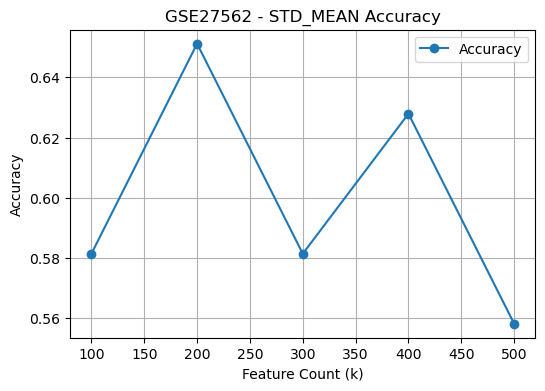

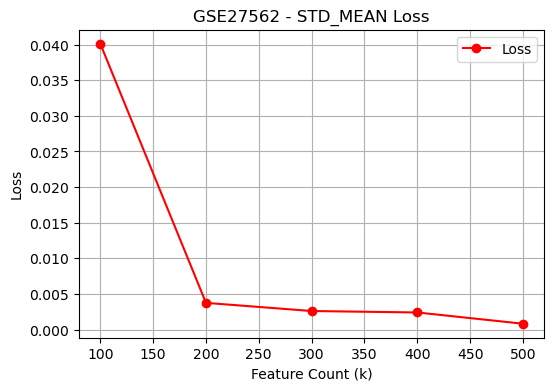

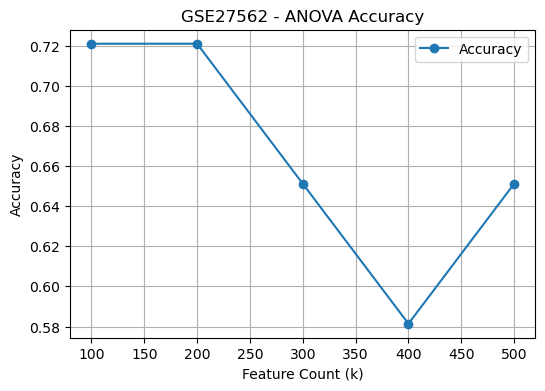

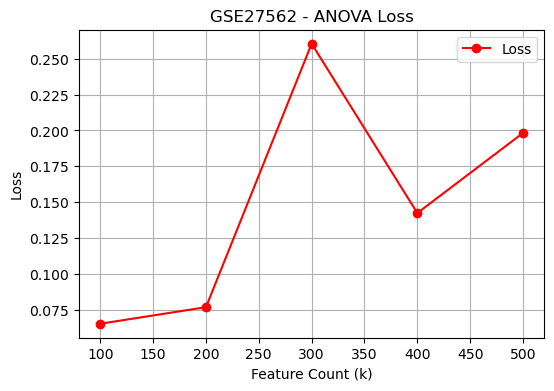

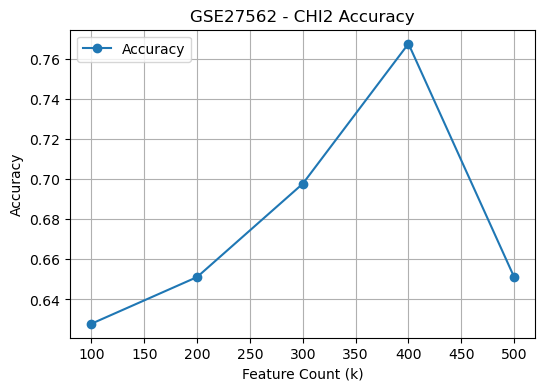

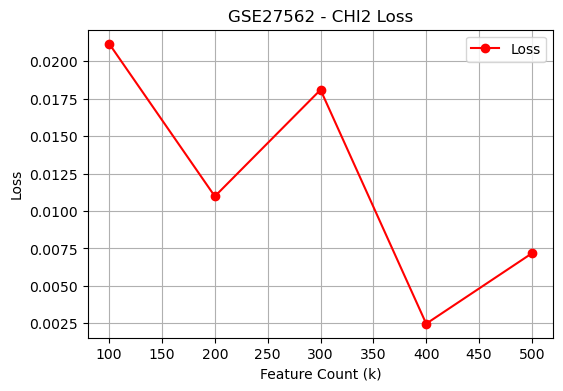

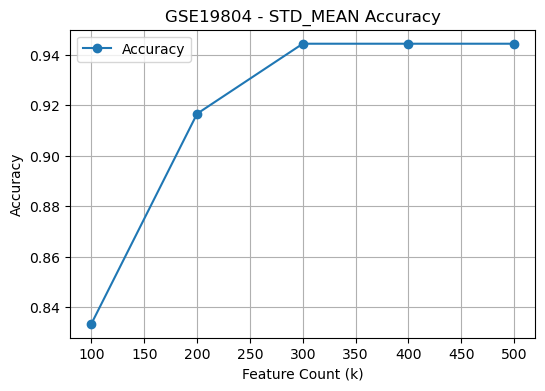

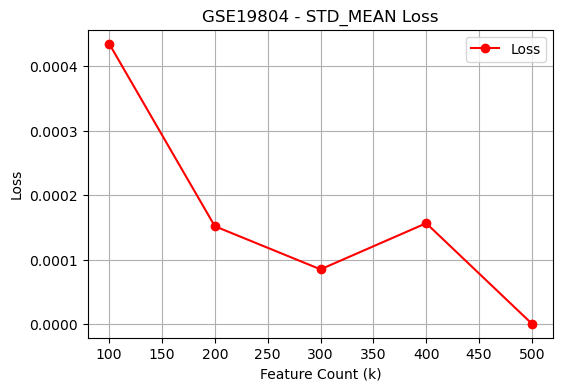

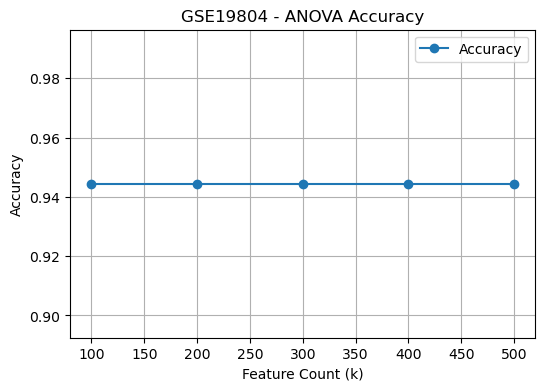

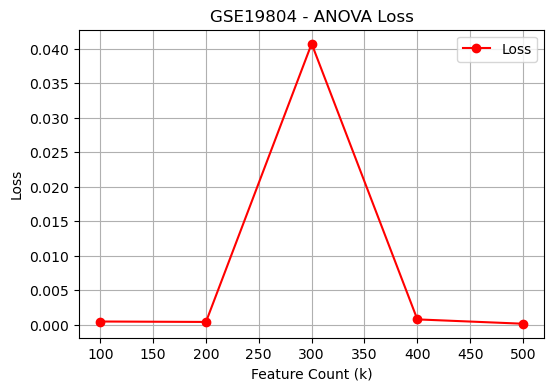

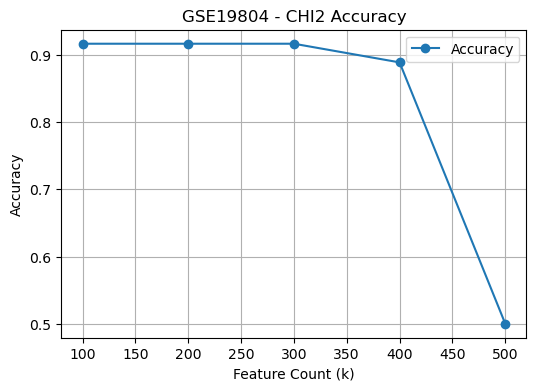

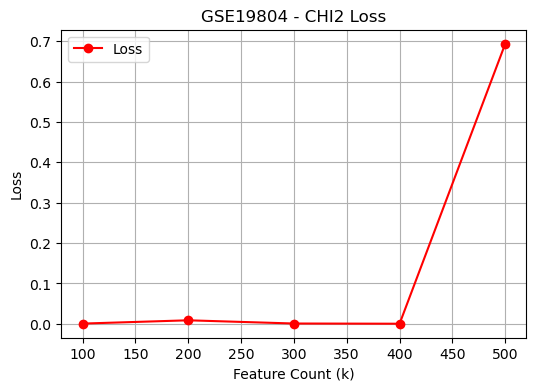

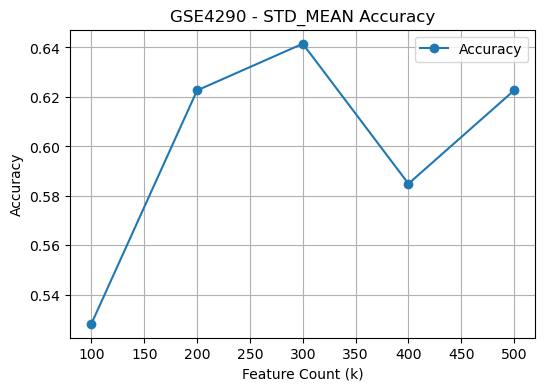

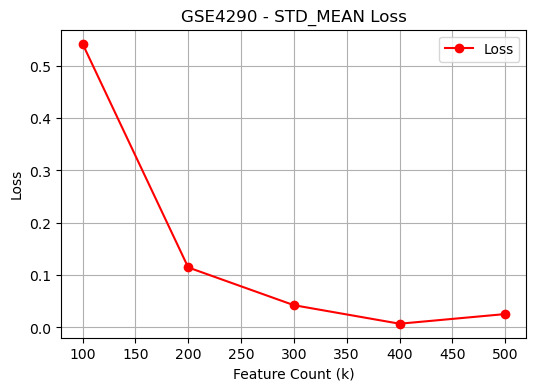

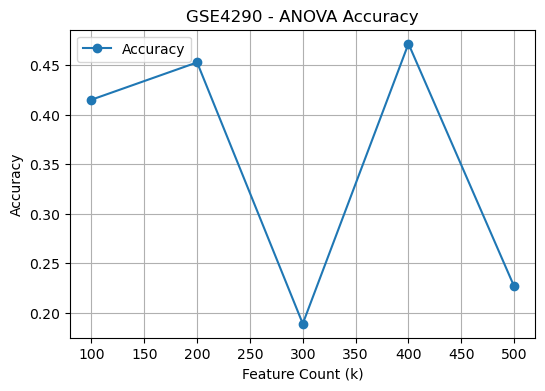

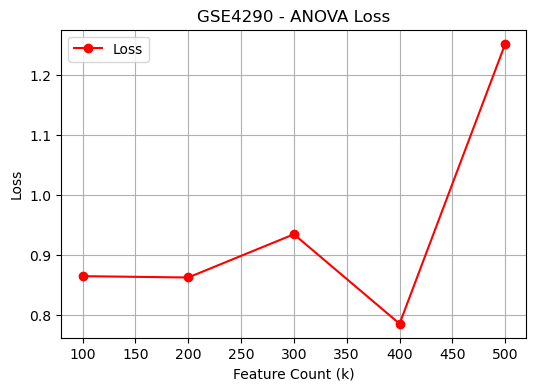

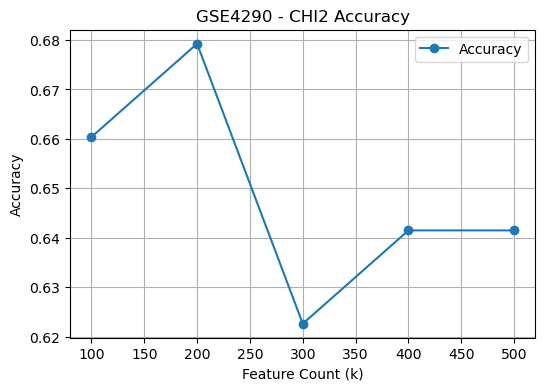

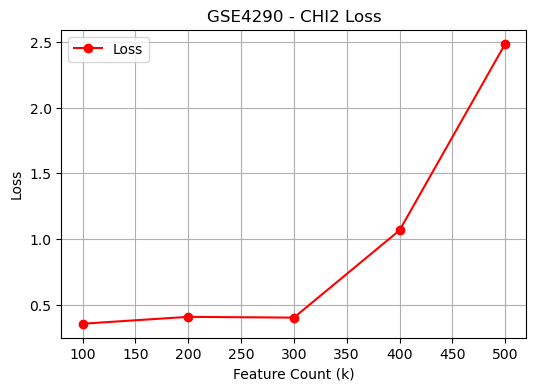

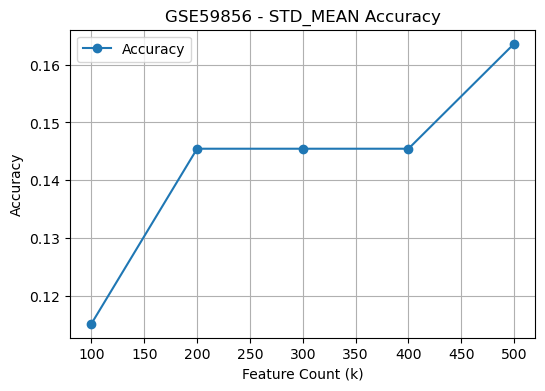

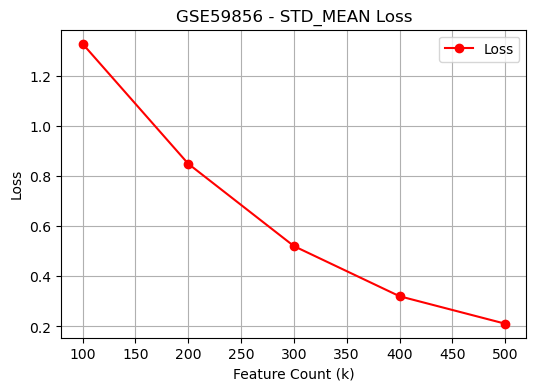

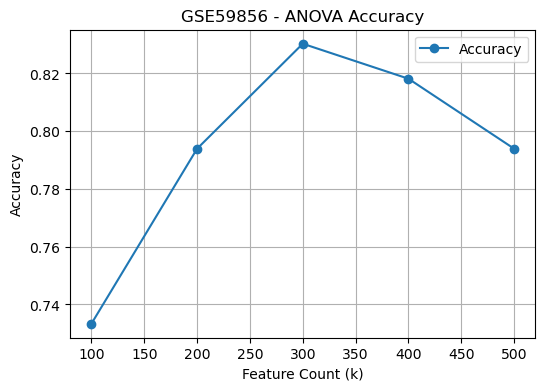

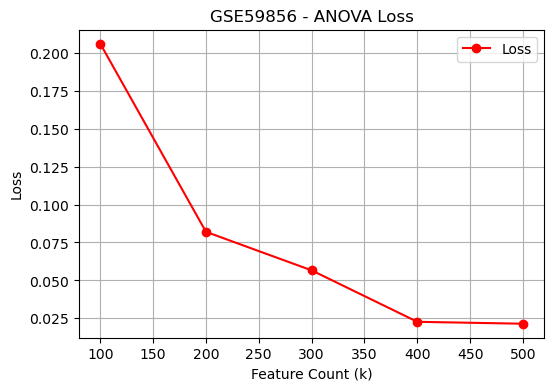

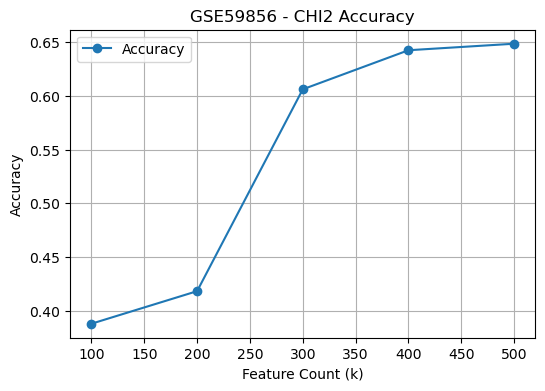

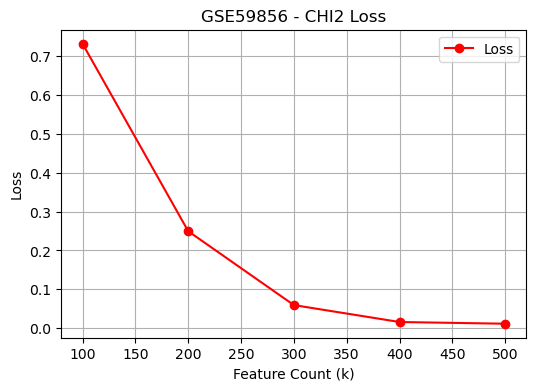

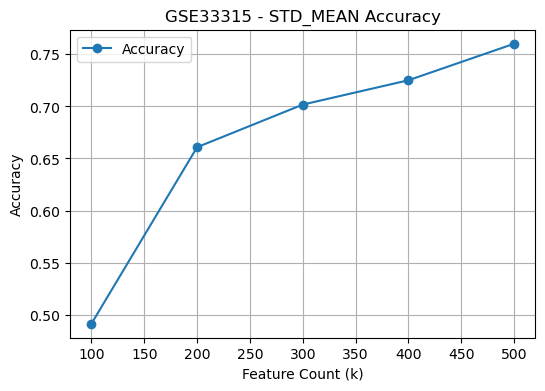

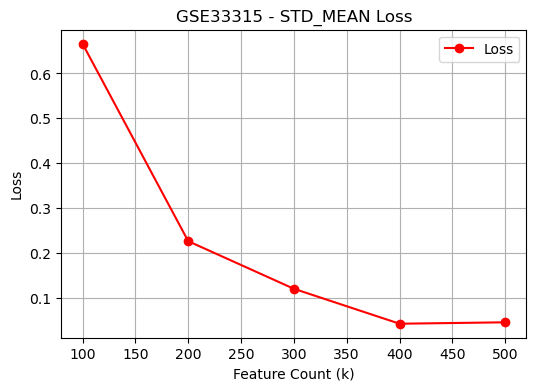

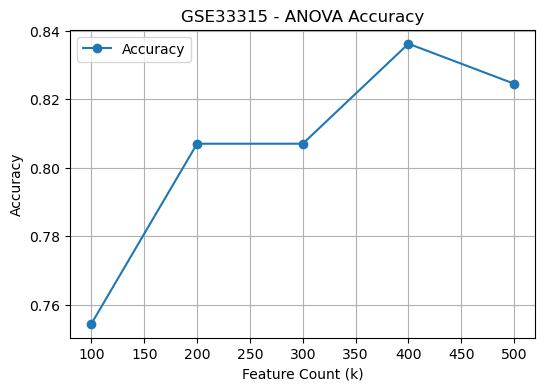

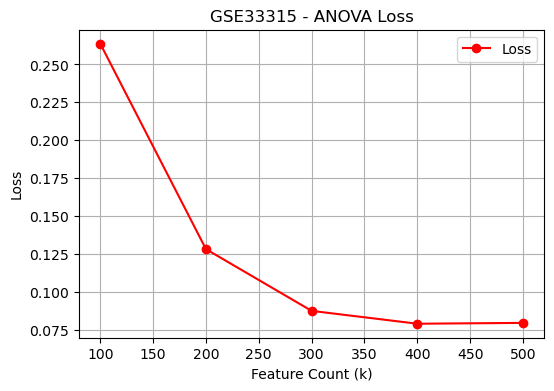

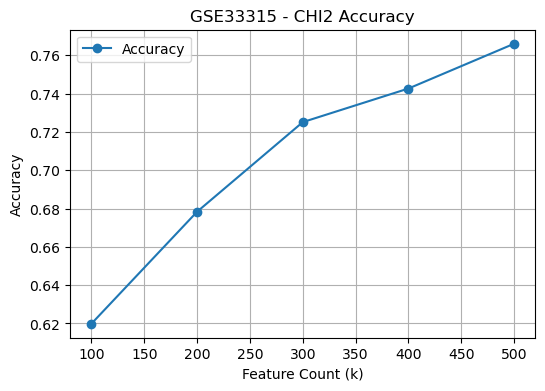

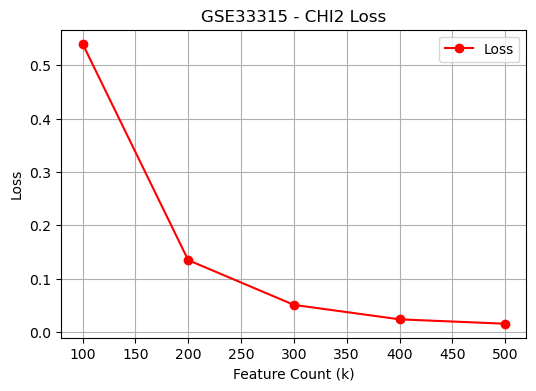

In [31]:

# Example usage
if __name__ == "__main__":
    datasets = [
        "GSE27562",
        "GSE19804",
        "GSE4290",
        "GSE59856",
        "GSE33315",
    ]
    target_column = "Target"
    output_dir = "preprocessed/selected_features"
    gnn_pipeline_for_selected_features(datasets, target_column, output_dir=output_dir)